In [1]:
import time
t1=time.time()

import logging
import os
import scanpy as sc
from hyperopt import hp

import datetime
import sys
import argparse
import anndata
import numpy as np
import ray
from ray import tune
import scvi
import scarches as sca

Global seed set to 0
 captum (see https://github.com/pytorch/captum).


In [17]:
pip list

Package                       Version
----------------------------- -------------------------
absl-py                       1.3.0
adjustText                    0.7.3
aiohttp                       3.8.3
aiohttp-cors                  0.7.0
aiorwlock                     1.3.0
aiosignal                     1.3.1
anndata                       0.8.0
anndata2ri                    1.1
anyio                         3.6.2
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
asttokens                     2.2.1
astunparse                    1.6.3
async-timeout                 4.0.2
attrs                         22.2.0
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.zoneinfo            0.2.1
beautifulsoup4                4.11.1
black                         23.1a1
bleach                        5.0.1
blessed                       1.20.0
cached-property               1.5.2
cachetools                    5.2.0
ce

Note: you may need to restart the kernel to use updated packages.


In [4]:
adata=sc.read("../../important_processed_data/4.12_wt_integrate_SCRAN_log1p_gene_filtered.h5ad")

In [5]:
model_cls = sca.models.SCVI
tuner = scvi.autotune.ModelTuner(model_cls)
tuner.info()
dispersions=["gene", "gene-batch"]
space = {
                "n_latent":  tune.qrandint(4,32,2),   # [5, 20]
                "n_hidden": tune.choice([64, 128, 256]),
                "n_layers":tune.qrandint(1,7,1),
                "dropout_rate":tune.choice([0.1, 0.3, 0.5, 0.7]),
                "gene_likelihood": tune.choice(["zinb", "nb"]),
                "dispersion": tune.choice(dispersions)
        }
adata.X = adata.layers['counts']
adata.raw = adata
raw = adata.raw.to_adata()
raw.X = adata.layers['counts']
adata.raw = raw
unlabeled = adata.obs.index[[ coarse_label != "Osteoblasts" for coarse_label in adata.obs.coarse_label]]
adata.obs['scanvi_label'] = adata.obs.coarse_label.tolist()
adata.obs.loc[unlabeled,'scanvi_label'] = "unlabeled"
condition_key = 'batch'
cell_type_key = 'scanvi_label'
unlabeled_category = "unlabeled"
sca.models.SCVI.setup_anndata(adata, batch_key=condition_key, labels_key=cell_type_key)
nlatent=10

ModelTuner registry for SCVI

                  Tunable hyperparameters                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃      Hyperparameter      ┃ Default value ┃    Source    ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│         n_hidden         │      128      │     VAE      │
│         n_latent         │      10       │     VAE      │
│         n_layers         │       1       │     VAE      │
│       dropout_rate       │      0.1      │     VAE      │
│        dispersion        │     gene      │     VAE      │
│     gene_likelihood      │     zinb      │     VAE      │
│   latent_distribution    │    normal     │     VAE      │
│    encode_covariates     │     False     │     VAE      │
│ deeply_inject_covariates │     True      │     VAE      │
│      use_batch_norm      │     both      │     VAE      │
│      use_layer_norm      │     none      │     VAE      │
│        optimizer         │     Adam      │ TrainingPlan │
│            lr            │     0.001     │ TrainingPlan │
│       weight_decay       │     1e-06     │ TrainingPlan │
│           eps            │     0.01      │ TrainingPlan │
│    n_steps_kl_warmup     │     None      │ TrainingPlan │
│    n_epochs_kl_warmup    │      400      │ TrainingPlan │
│   reduce_lr_on_plateau   │     False     │ TrainingPlan │
│        lr_factor         │      0.6      │ TrainingPlan │
│       lr_patience        │      30       │ TrainingPlan │
│       lr_threshold       │      0.0      │ TrainingPlan │
│          lr_min          │       0       │ TrainingPlan │
│      max_kl_weight       │      1.0      │ TrainingPlan │
│      min_kl_weight       │      0.0      │ TrainingPlan │
└──────────────────────────┴───────────────┴──────────────┘

       Available metrics        
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃     Metric      ┃    Mode    ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ validation_loss │    min     │
└─────────────────┴────────────┘

                         Default search space                         
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Hyperparameter ┃ Sample function ┃  Arguments  ┃ Keyword arguments ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│    n_hidden    │     choice      │ [[64, 128]] │        {}         │
└────────────────┴─────────────────┴─────────────┴───────────────────┘

/home/gilberthan/anaconda3/envs/scarches/lib/python3.8/site-packages/scvi/data/fields/_layer_field.py:91: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [ ]:
results = tuner.fit(adata, metric="validation_loss",search_space=space,num_samples=100)

2023-04-13 00:09:59,634	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
(pid=2035626) Global seed set to 0
(_trainable pid=2035626) No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
(_trainable pid=2035626) /home/gilberthan/anaconda3/envs/scarches/lib/python3.8/site-packages/scvi/data/fields/_layer_field.py:91: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
(_trainable pid=2035626)   warnings.warn(
(_trainable pid=2035626) /home/gilberthan/anaconda3/envs/scarches/lib/python3.8/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
(_trainable pid=2035626)   warnings.warn("Can't initialize NVML")
(_trainable pid=2035626) GPU available: False, used: False
(_trainable pid=2035626) TPU available: False, using: 0 TPU cores
(_trainable pid=2035626) IPU available: False, using: 0 IPUs
(_trainable pid=2035626) HPU available: Fals

(_trainable pid=2035991) /home/gilberthan/anaconda3/envs/scarches/lib/python3.8/site-packages/scvi/data/fields/_layer_field.py:91: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
(_trainable pid=2035991)   warnings.warn(
(_trainable pid=2036214) /home/gilberthan/anaconda3/envs/scarches/lib/python3.8/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
(_trainable pid=2036214)   warnings.warn("Can't initialize NVML")
(_trainable pid=2036214) GPU available: False, used: False
(_trainable pid=2036214) TPU available: False, using: 0 TPU cores
(_trainable pid=2036214) IPU available: False, using: 0 IPUs
(_trainable pid=2036214) HPU available: False, using: 0 HPUs
(_trainable pid=2036139) /home/gilberthan/anaconda3/envs/scarches/lib/python3.8/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
(_trainable pid=2036139)   warnings.warn("Can't initialize NVML")
(_trainable pid=2036139) GPU availa

(_trainable pid=2038758) No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
(_trainable pid=2038758) /home/gilberthan/anaconda3/envs/scarches/lib/python3.8/site-packages/scvi/data/fields/_layer_field.py:91: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
(_trainable pid=2038758)   warnings.warn(
(_trainable pid=2038534) No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
(_trainable pid=2038164) /home/gilberthan/anaconda3/envs/scarches/lib/python3.8/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
(_trainable pid=2038164)   warnings.warn("Can't initialize NVML")
(_trainable pid=2038164) GPU available: False, used: False
(_trainable pid=2038333) /home/gilberthan/anaconda3/envs/scarches/lib/python3.8/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
(_trainable pid=2038333)   warnings.warn("Can't initi

(_trainable pid=2038758) /home/gilberthan/anaconda3/envs/scarches/lib/python3.8/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
(_trainable pid=2038758)   warnings.warn("Can't initialize NVML")
(_trainable pid=2038758) GPU available: False, used: False
(_trainable pid=2039100) /home/gilberthan/anaconda3/envs/scarches/lib/python3.8/site-packages/scvi/data/fields/_layer_field.py:91: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
(_trainable pid=2039100)   warnings.warn(
(_trainable pid=2039999) No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
(_trainable pid=2038758) TPU available: False, using: 0 TPU cores
(_trainable pid=2038758) IPU available: False, using: 0 IPUs
(_trainable pid=2038758) HPU available: False, using: 0 HPUs
(_trainable pid=2038534) /home/gilberthan/anaconda3/envs/scarches/lib/python3.8/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't

(_trainable pid=2039307) /home/gilberthan/anaconda3/envs/scarches/lib/python3.8/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
(_trainable pid=2039307)   warnings.warn("Can't initialize NVML")
(_trainable pid=2039307) GPU available: False, used: False
(_trainable pid=2039919) No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
(_trainable pid=2039307) TPU available: False, using: 0 TPU cores
(_trainable pid=2039307) IPU available: False, using: 0 IPUs
(_trainable pid=2039307) HPU available: False, using: 0 HPUs
(_trainable pid=2039227) /home/gilberthan/anaconda3/envs/scarches/lib/python3.8/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
(_trainable pid=2039227)   warnings.warn("Can't initialize NVML")
(_trainable pid=2039227) GPU available: False, used: False
(_trainable pid=2039227) TPU available: False, using: 0 TPU cores
(_trainable pid=2039227) IPU available: False, using: 0 IPUs
(_t

(_trainable pid=2039997) /home/gilberthan/anaconda3/envs/scarches/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:481: UserWarning: The value argument must be within the support of the distribution
(_trainable pid=2039997)   warnings.warn(
(_trainable pid=2040044) /home/gilberthan/anaconda3/envs/scarches/lib/python3.8/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
(_trainable pid=2040044)   warnings.warn("Can't initialize NVML")
(_trainable pid=2040044) GPU available: False, used: False
(_trainable pid=2039919) /home/gilberthan/anaconda3/envs/scarches/lib/python3.8/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
(_trainable pid=2039919)   warnings.warn("Can't initialize NVML")
(_trainable pid=2039919) GPU available: False, used: False
(_trainable pid=2040044) TPU available: False, using: 0 TPU cores
(_trainable pid=2040044) IPU available: False, using: 0 IPUs
(_trainable pid=2040044) HPU available: False, u

In [7]:
results

TuneAnalysis(model_kwargs={'n_latent': 18, 'n_hidden': 256, 'n_layers': 4, 'dropout_rate': 0.1, 'gene_likelihood': 'zinb', 'dispersion': 'gene-batch'}, train_kwargs={'plan_kwargs': {}}, metric={'metric': 'validation_loss', 'mode': 'min', 'value': 1035.82373046875}, additional_metrics={}, search_space={'n_latent': <ray.tune.search.sample.Integer object at 0x7f4693fe2d90>, 'n_hidden': <ray.tune.search.sample.Categorical object at 0x7f46afd321c0>, 'n_layers': <ray.tune.search.sample.Integer object at 0x7f46afd326d0>, 'dropout_rate': <ray.tune.search.sample.Categorical object at 0x7f469bbbefa0>, 'gene_likelihood': <ray.tune.search.sample.Categorical object at 0x7f469bbbee80>, 'dispersion': <ray.tune.search.sample.Categorical object at 0x7f469bbbef40>}, results=<ray.tune.result_grid.ResultGrid object at 0x7f46a7962ca0>)

In [8]:
pltDf=results.results.get_dataframe()

In [9]:
import seaborn as sb

<AxesSubplot: xlabel='config/n_latent', ylabel='validation_loss'>

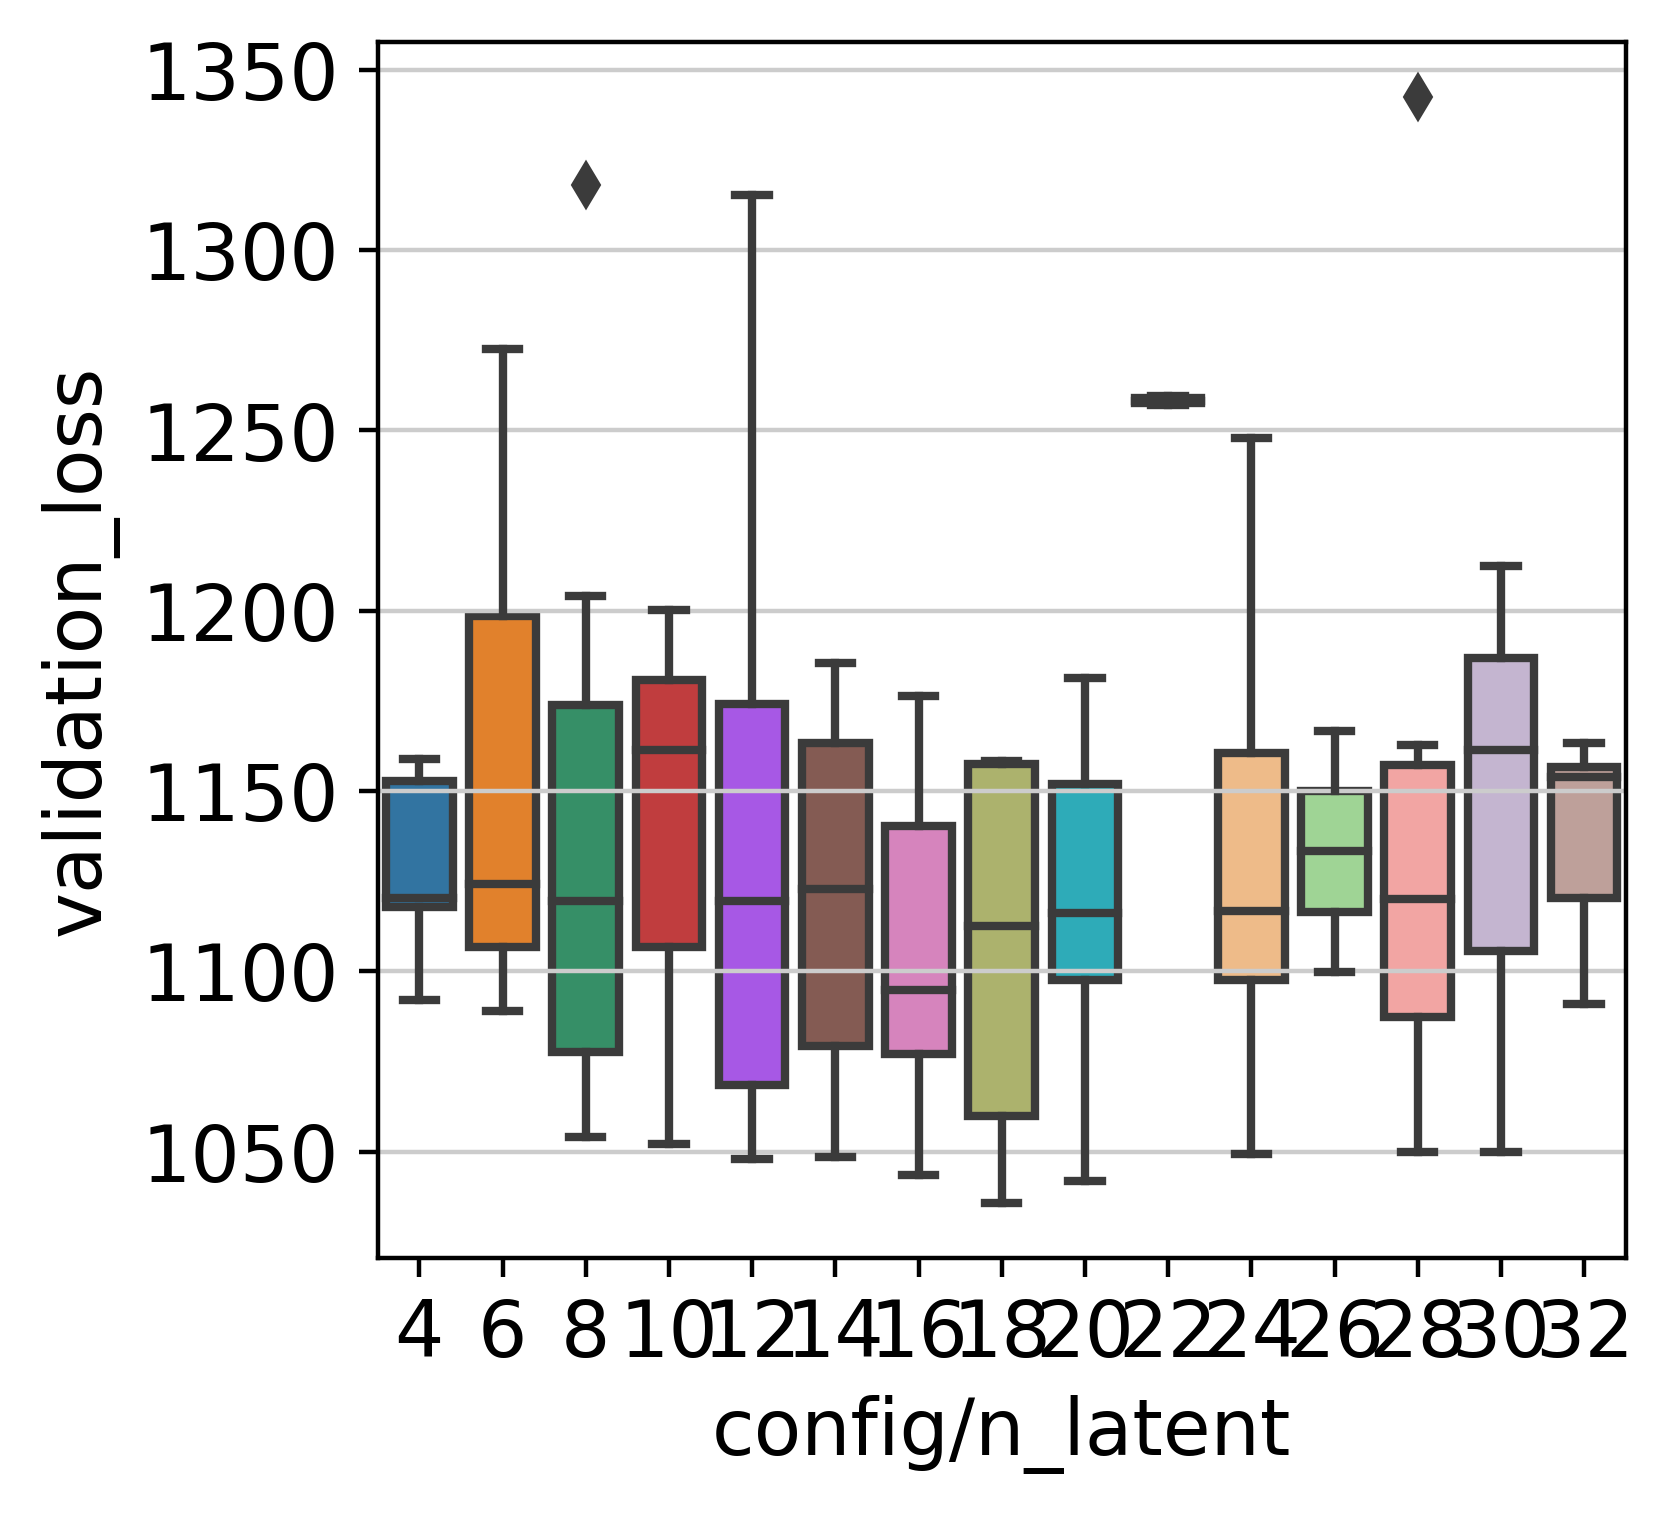

In [10]:
sb.boxplot(x="config/n_latent",y="validation_loss",data=pltDf)

<AxesSubplot: xlabel='config/gene_likelihood', ylabel='validation_loss'>

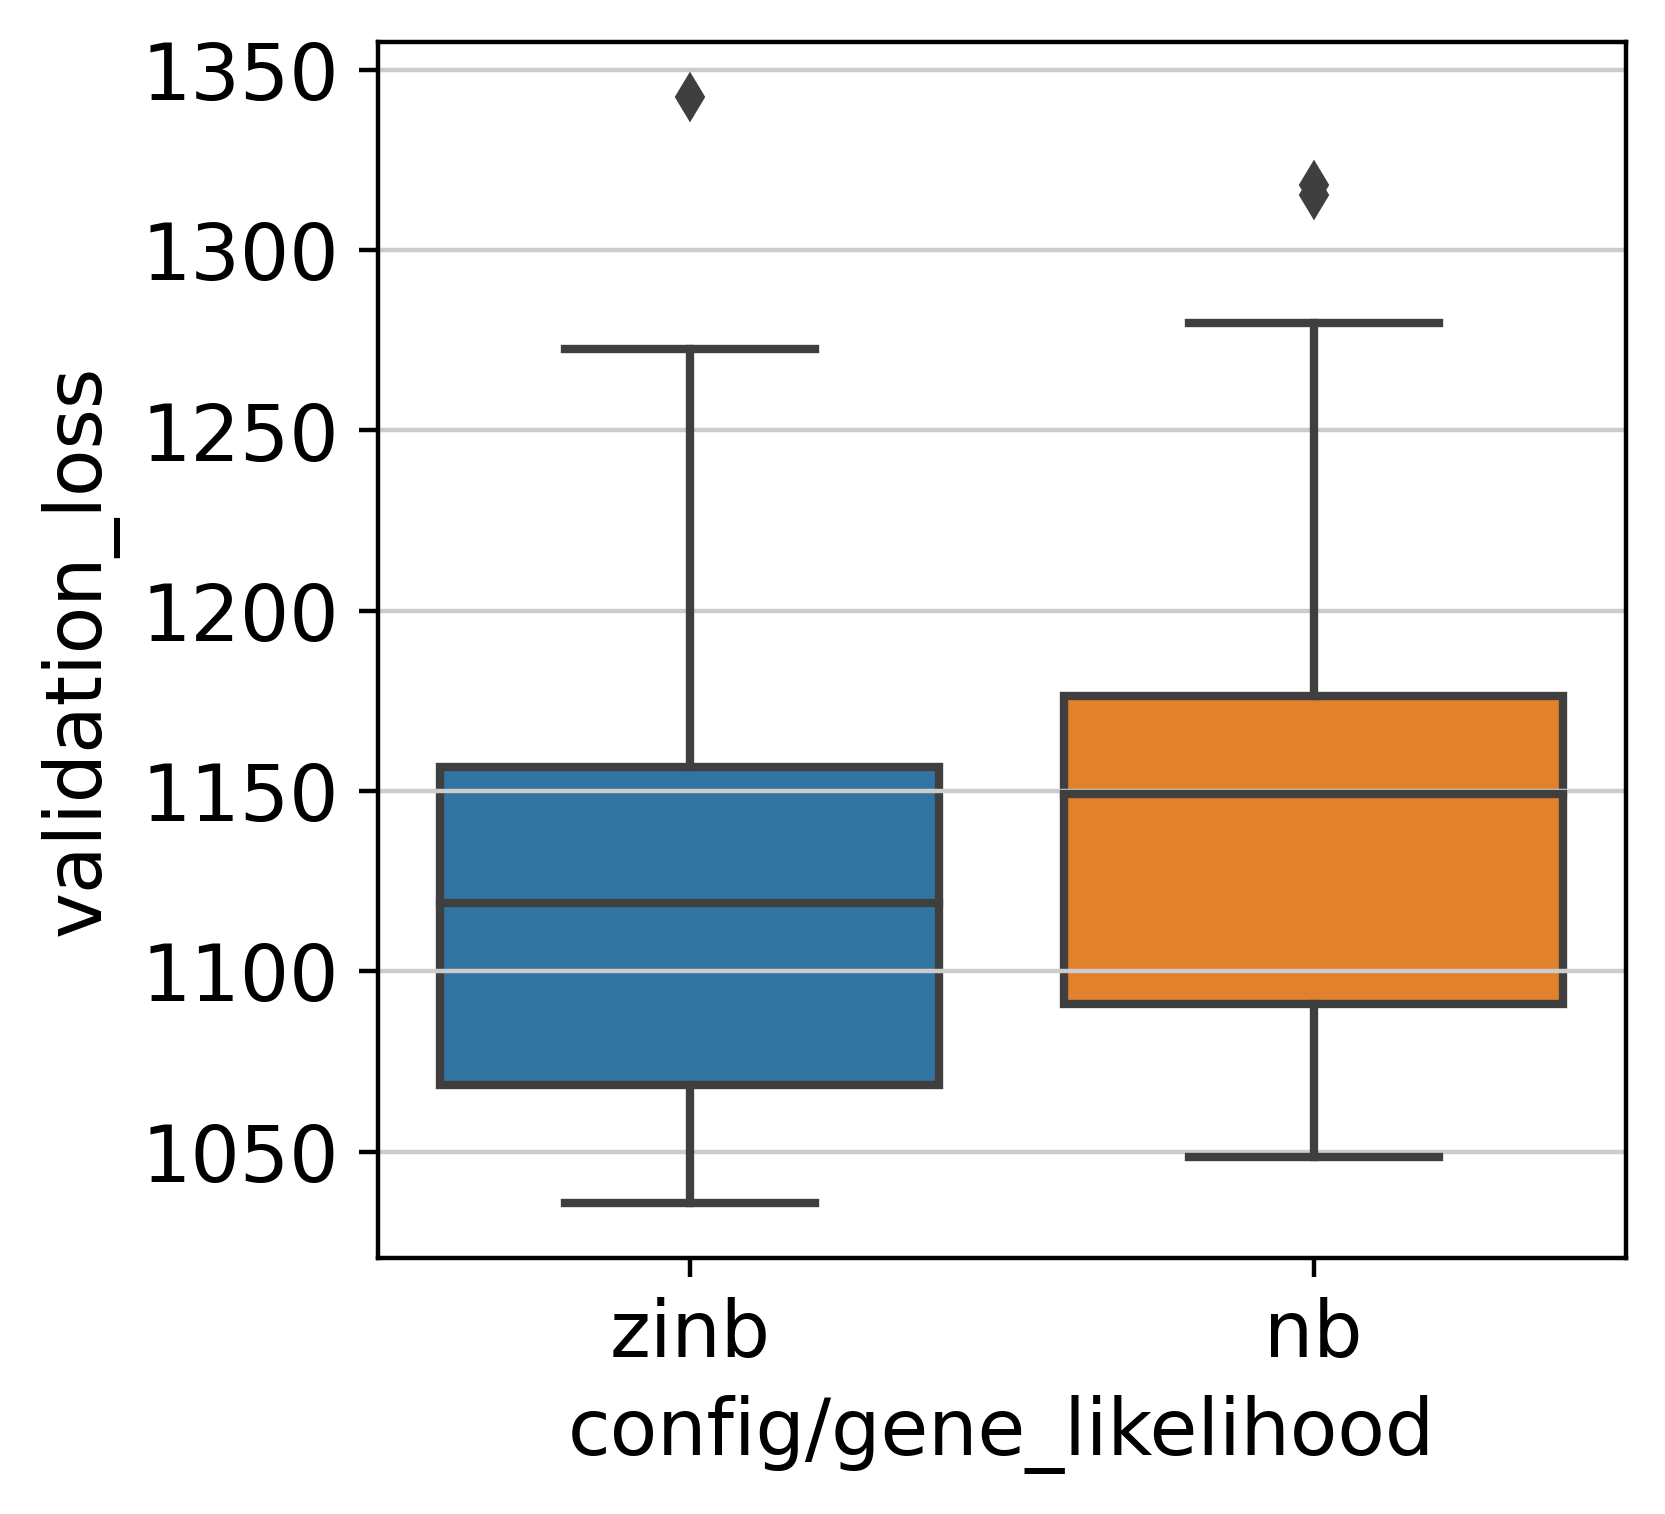

In [11]:
sb.boxplot(x="config/gene_likelihood",y="validation_loss",data=pltDf)

<AxesSubplot: xlabel='config/dropout_rate', ylabel='validation_loss'>

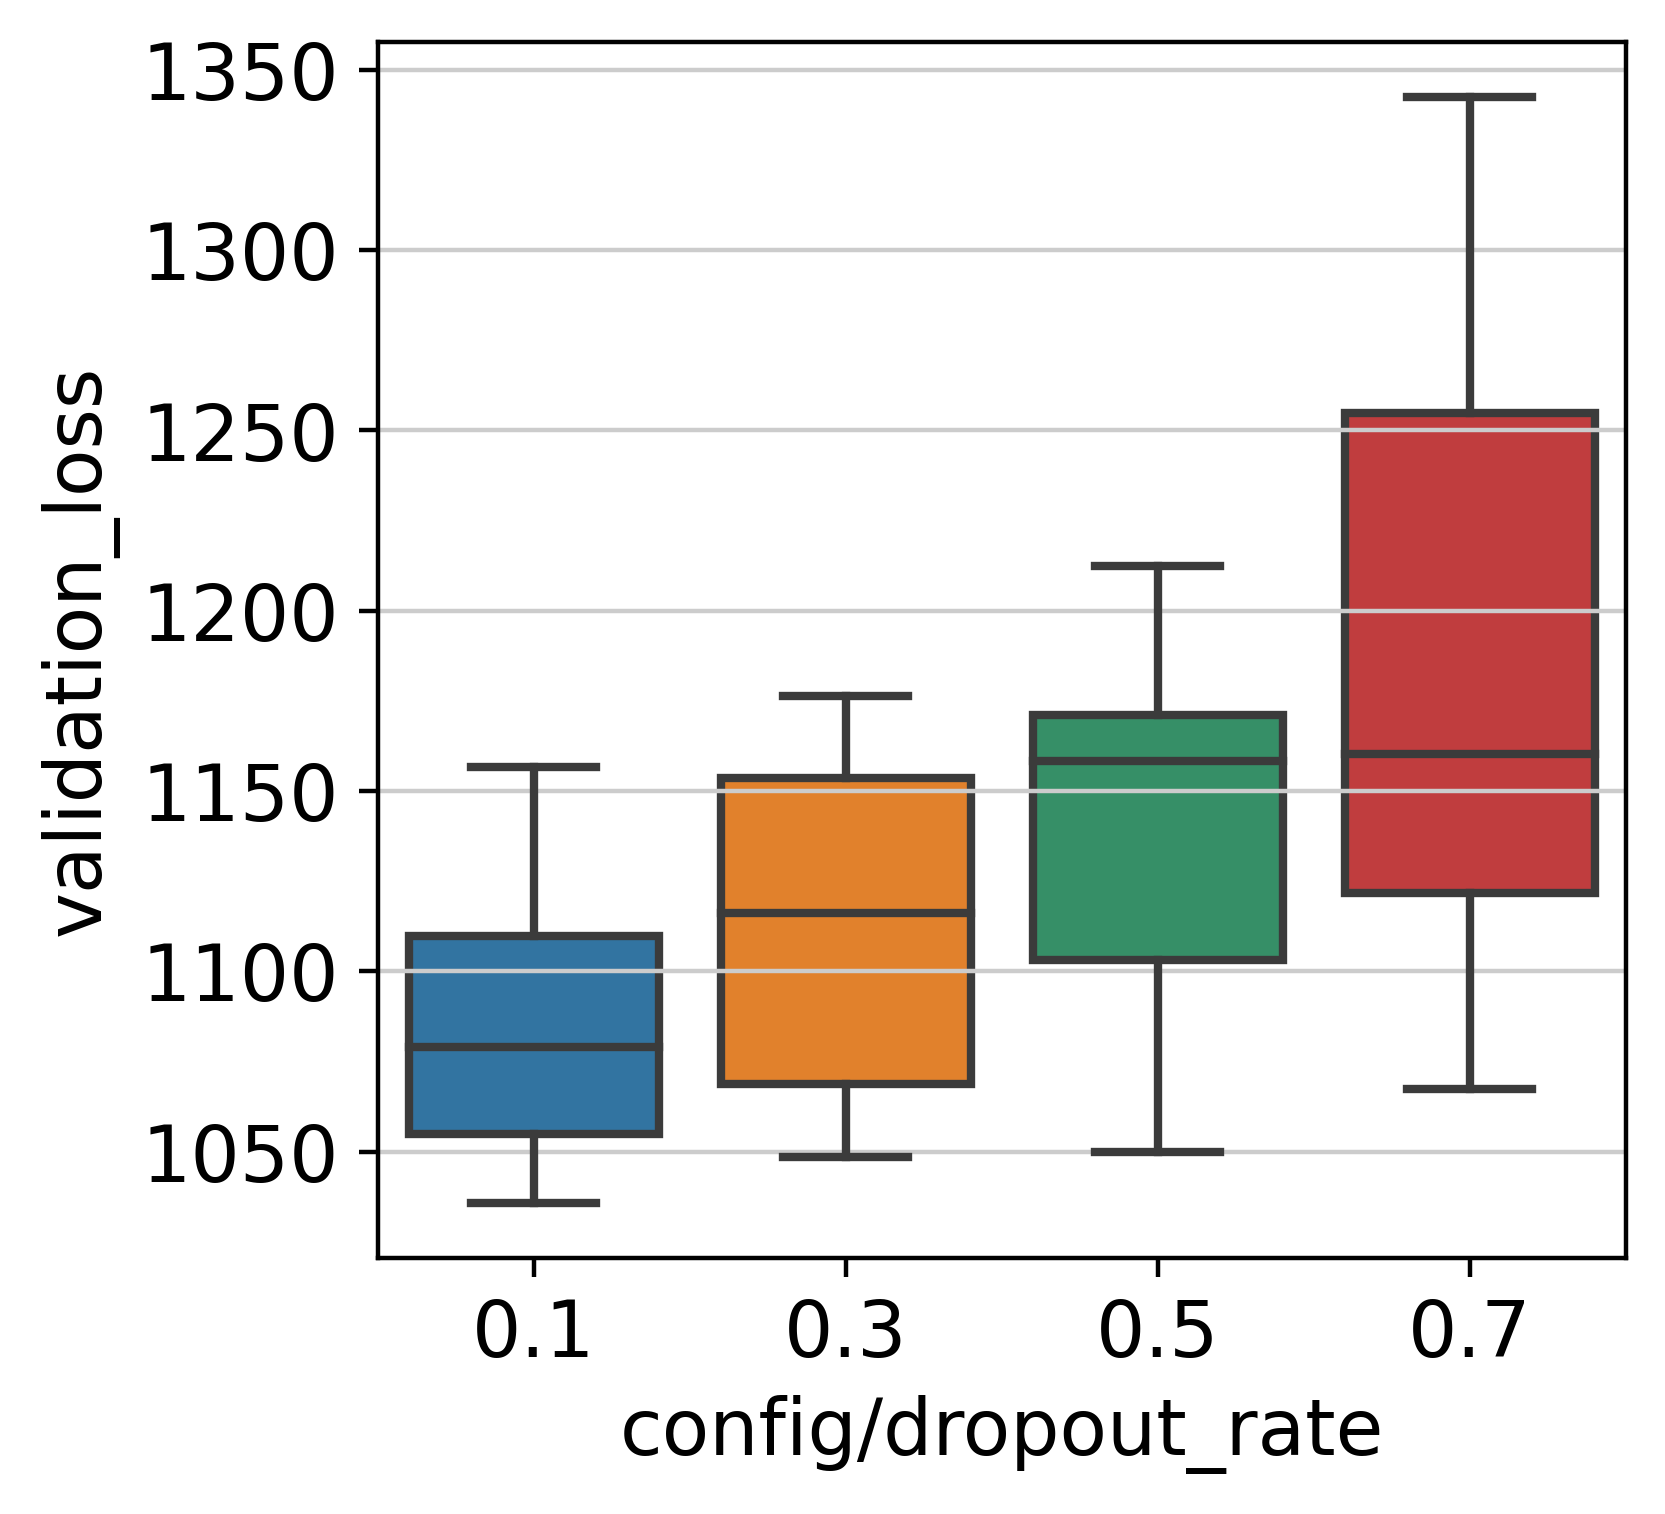

In [12]:
sb.boxplot(x="config/dropout_rate",y="validation_loss",data=pltDf)

<AxesSubplot: xlabel='config/n_layers', ylabel='validation_loss'>

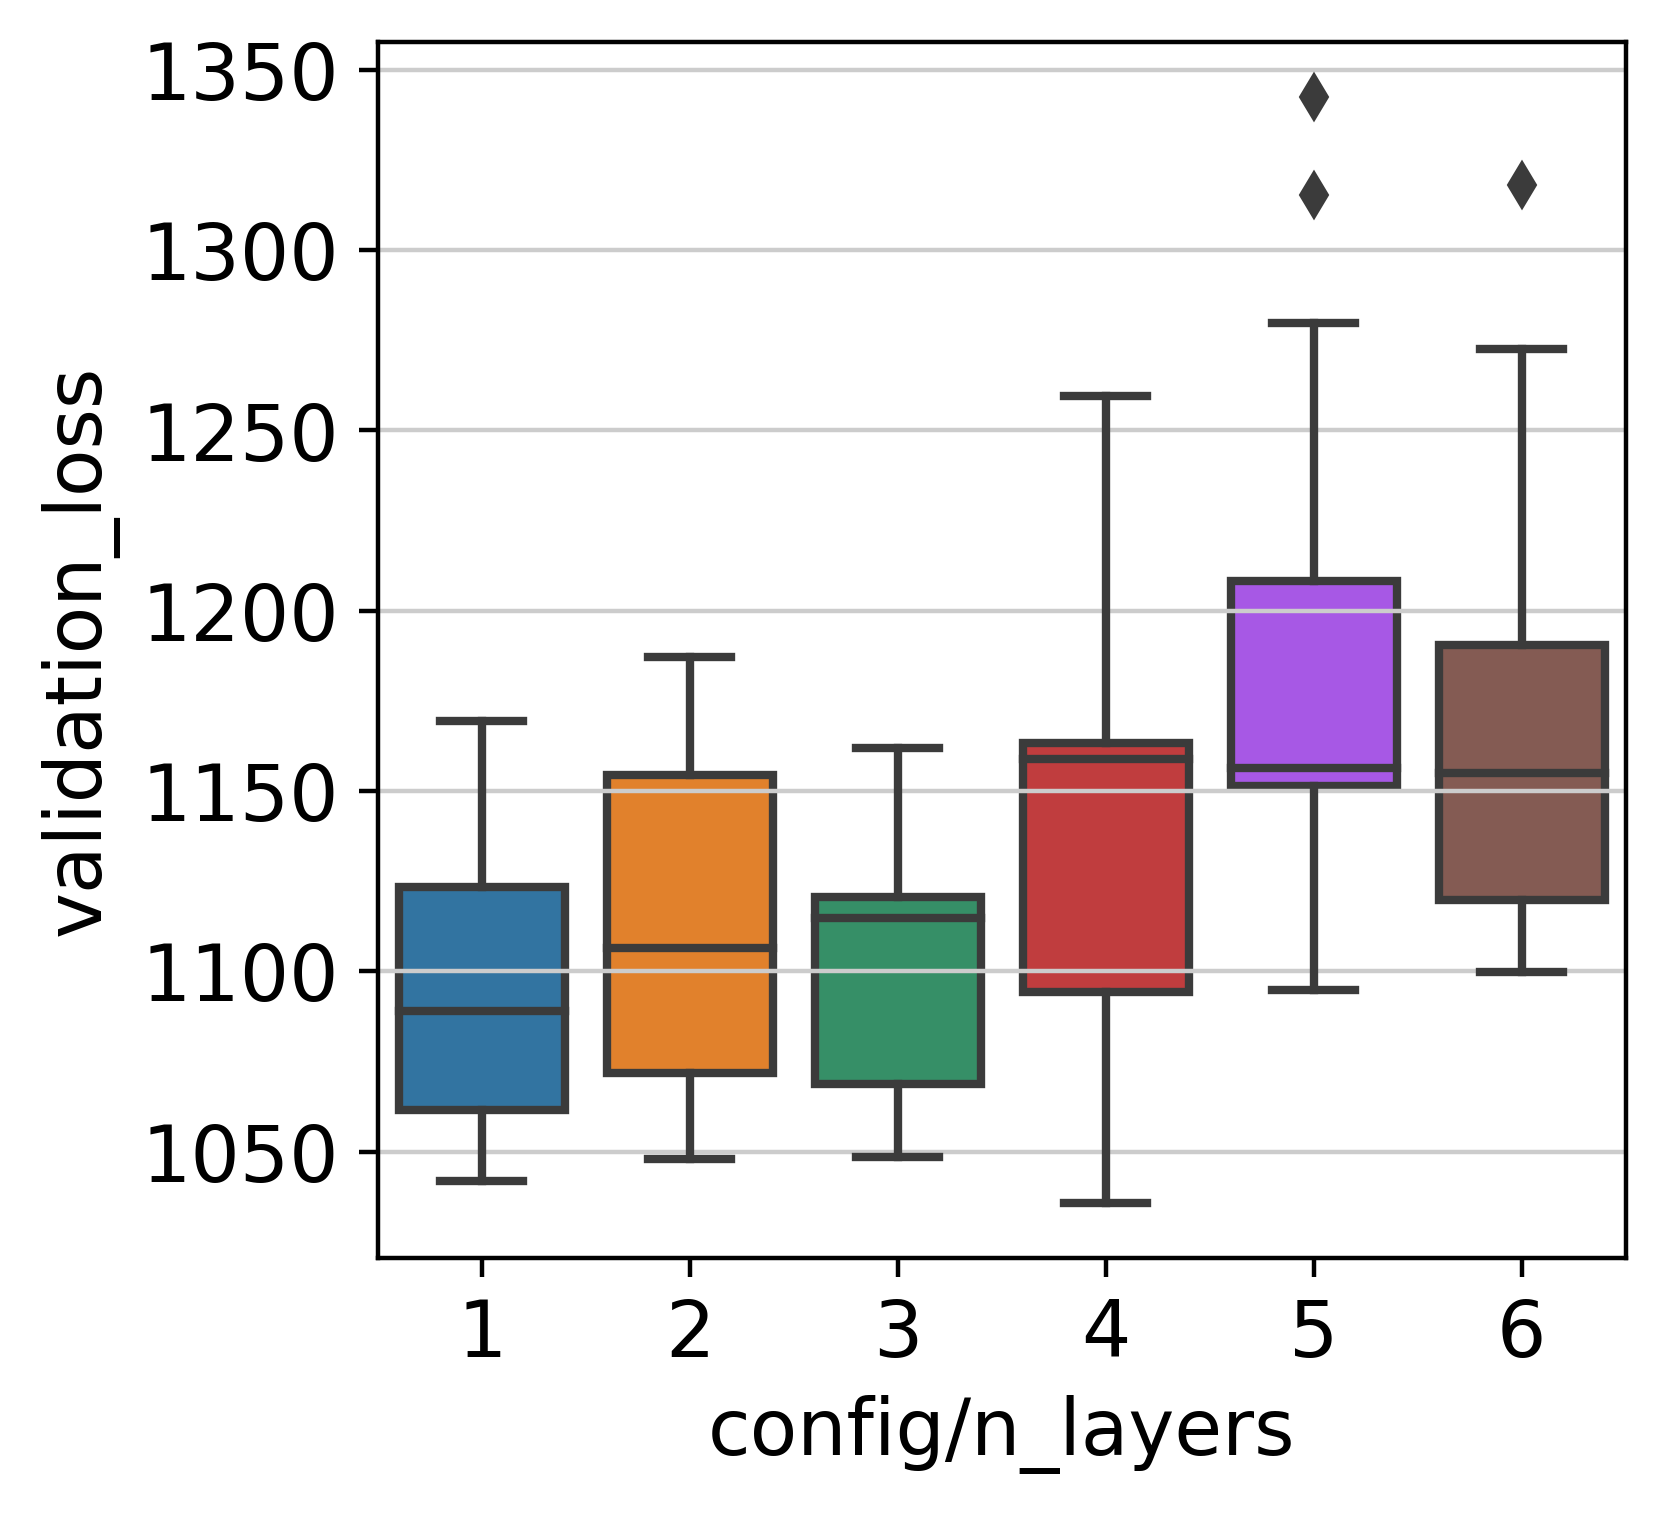

In [13]:
sb.boxplot(x="config/n_layers",y="validation_loss",data=pltDf)

<AxesSubplot: xlabel='config/dispersion', ylabel='validation_loss'>

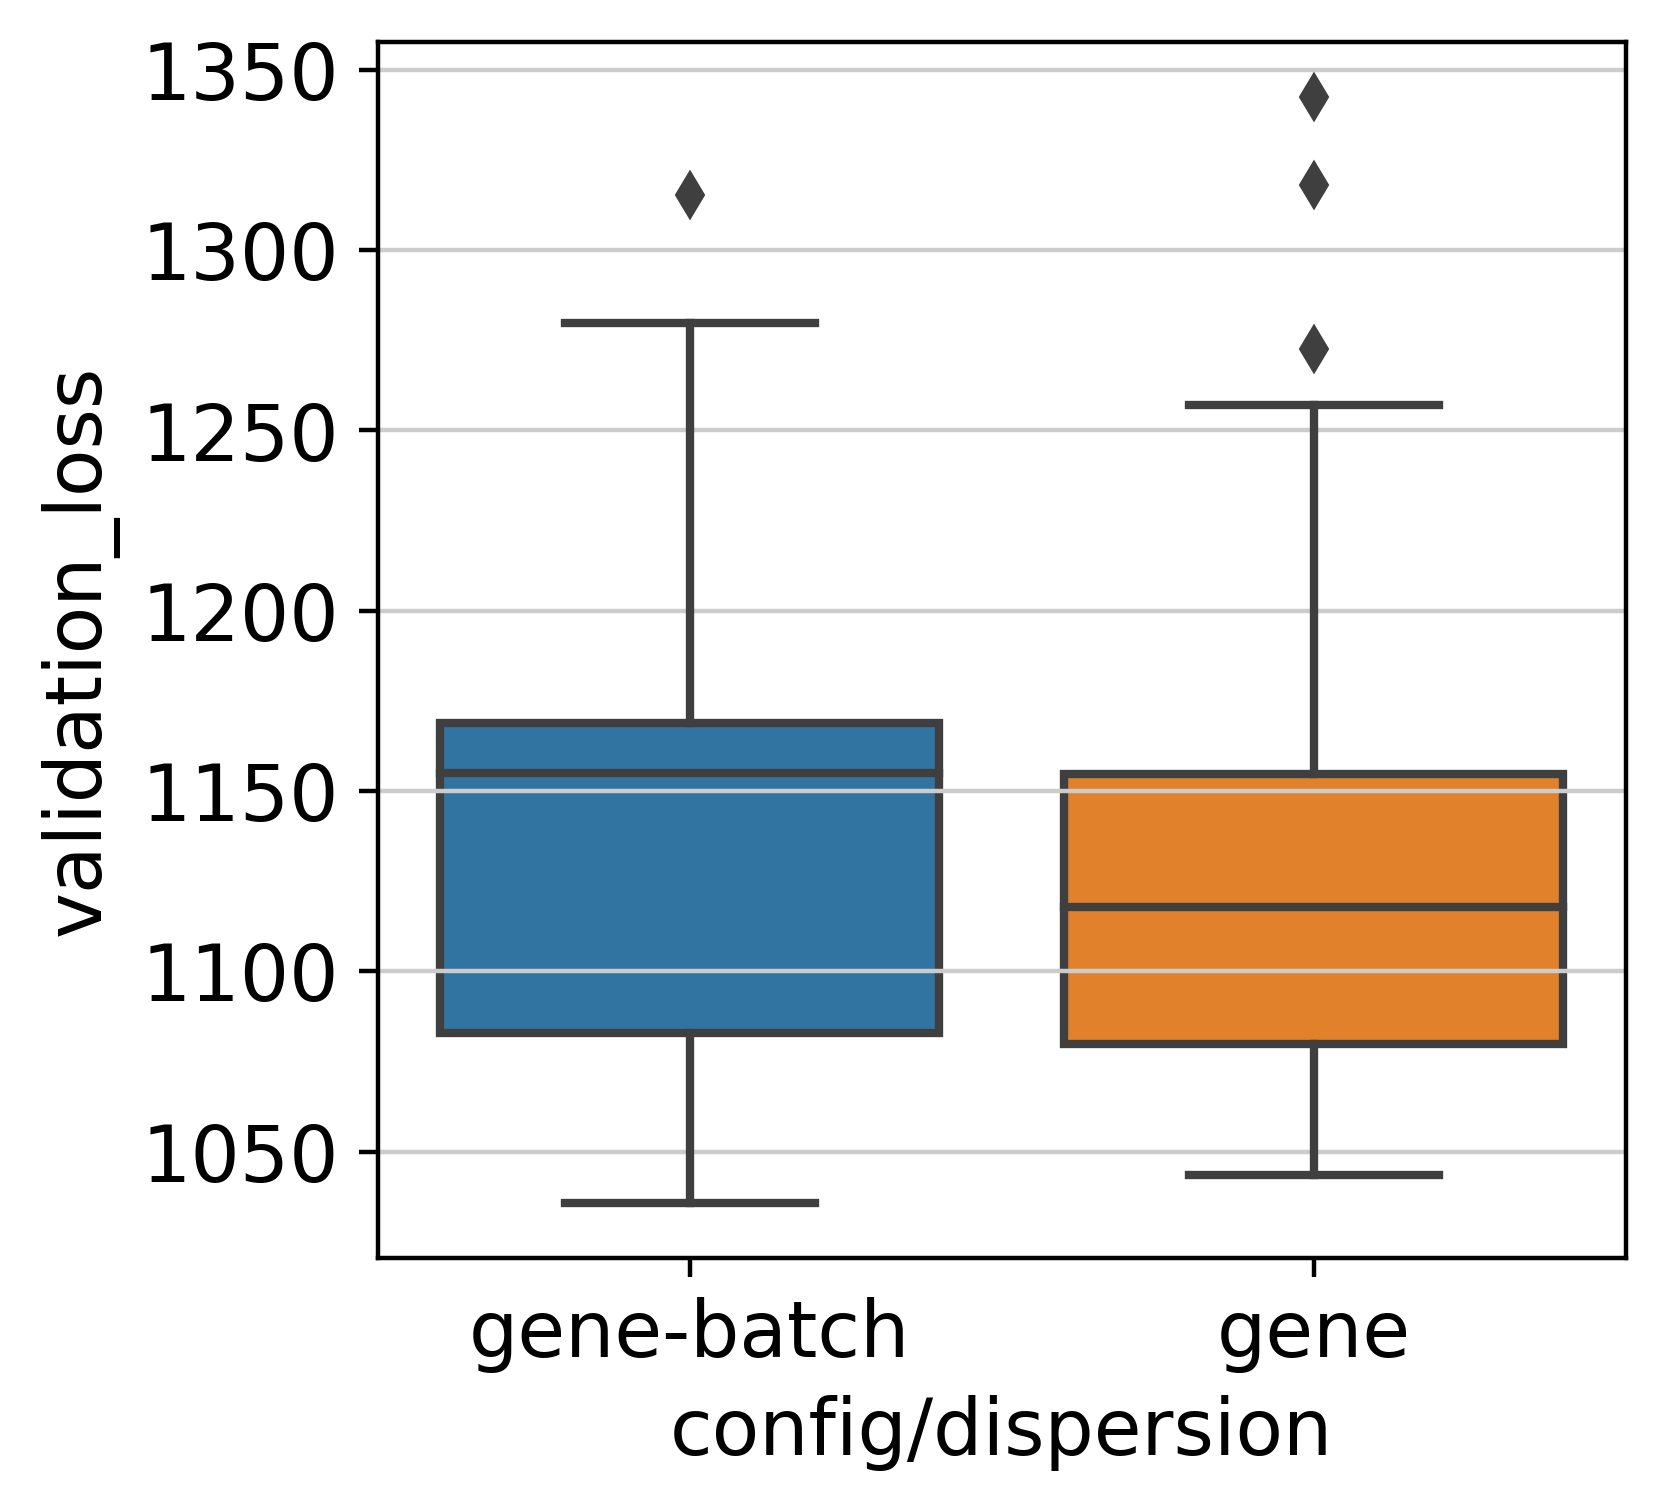

In [14]:
sb.boxplot(x="config/dispersion",y="validation_loss",data=pltDf)

<AxesSubplot: xlabel='iterations_since_restore', ylabel='validation_loss'>

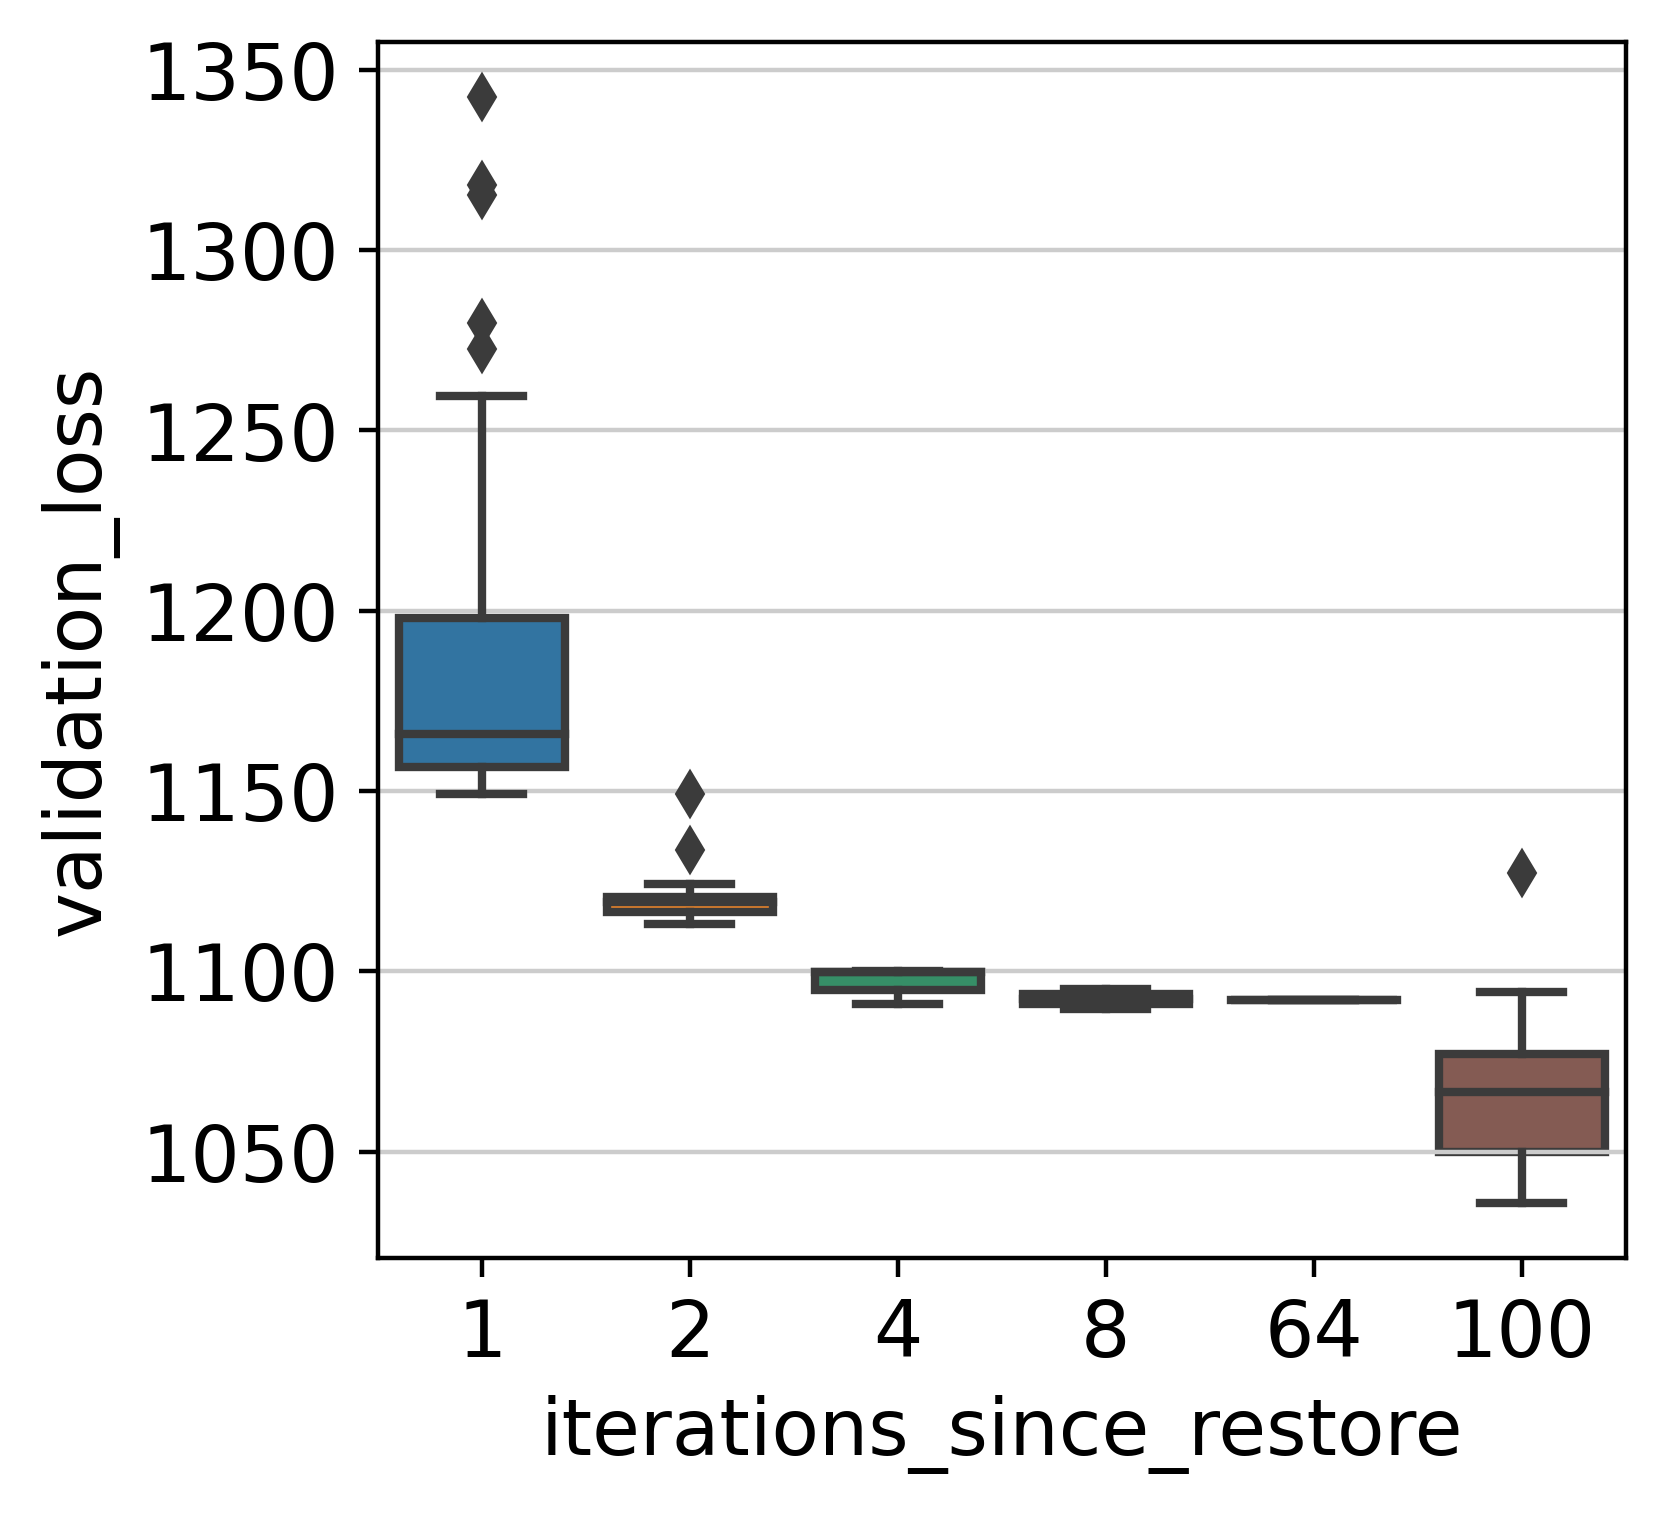

In [15]:
sb.boxplot(x="iterations_since_restore",y="validation_loss",data=pltDf)

In [16]:
pltDf.to_csv("../result/hypertune/4.13_hypertune100.csv")

In [ ]:
vae = sca.models.SCVI(
    adata,
    n_latent=nlatent,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
    )